# Classifying trialwise CorrectGo and NoGo trials

There are a number of steps to this. Hopefully we can recycle previous code and be up fairly quickly!

1. Load beta data. Ideally this process should include a cache into a pure python object so we don't have to reload it each time.
2. Preprocess the data.
3. Do cross-validated training and testing. Ideally an inner loop to select best parameters, an outer loop to get cross-validated performance, and final training over all the data to get an image. The inner loop can be probably be handled within the package we use probably.

In [74]:
import sys
import os
import pandas as pd
import numpy as np



sys.path.append(os.path.abspath("../../ml/"))
from apply_loocv_and_save import load_and_preprocess
from dev_utils import read_yaml_for_host
import warnings


config_data = read_yaml_for_host("sst_config.yml")



In [2]:
import multiprocessing
import math
import nibabel as nib
import nilearn as nl
from nilearn.decoding import DecoderRegressor,Decoder
from sklearn.model_selection import KFold,GroupKFold,LeaveOneOut
cpus_available = multiprocessing.cpu_count()

cpus_to_use = min(cpus_available-1,math.floor(0.9*cpus_available))
print(cpus_to_use)

9


In [3]:
from dev_wtp_io_utils import cv_train_test_sets, asizeof_fmt
from nilearn.decoding import DecoderRegressor,Decoder

In [4]:
nonbids_data_path = config_data['nonbids_data_path']
ml_data_folderpath = nonbids_data_path + "fMRI/ml"


## Set up the paradigm

In [5]:

def trialtype_resp_trans_func(X):
    return(X.trial_type)


## Loading beta data

beta data is generally written in `load_multisubject_brain_data_sst_w1.ipynb`.

We just have to load it.

In [6]:
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_30subs_correct_cond_pfc.pkl'
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_2subs_correct_cond_pfc.pkl'
warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20220818T144138.csv"

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_10596/442391669.py:3: UserWarning: not sure if this file holds up--it was created in 2021; need to see if it's still valid
  warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")


In [7]:


all_subjects = load_and_preprocess(
    brain_data_filepath,
    train_test_markers_filepath,
    subjs_to_use = None,
    response_transform_func = trialtype_resp_trans_func,
    clean=None)

warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


checked for intersection and no intersection between the brain data and the subjects was found.
there were 2 subjects overlapping between the subjects marked for train data and the training dump file itself.


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


test_train_set: 62918
brain_data_filepath: 172
pkl_file: 168
train_test_markers_filepath: 158
response_transform_func: 144
sys: 72
Brain_Data_allsubs: 48
clean: 16
subjs_to_use: 16
195
195
cleaning memory


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_10596/1474138623.py:8: UserWarning: the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.
  warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


In [11]:
all_subjects['X'].shape

(97, 115, 97, 195)

In [55]:
img_std_signal

array([ 2.40641484,  6.16565233,  1.39700845,  3.82197252,  4.28057301,
        2.14737517,  2.46158852,  3.06783847,  5.08154921,  4.87398956,
        1.90658474,  1.67149771,  4.09974887,  2.4683288 ,  2.85134229,
        2.07687452,  1.84022439,  2.66836484,  1.79617661,  1.74015298,
        2.39447989,  2.31657667,  2.27748481, 13.77747435,  2.27482718,
        2.21712153,  2.25681476,  1.78962211,  2.71576783,  3.33867676,
        1.46974884,  3.84346906,  6.41834585,  2.22134288,  1.76487628,
        2.39660948,  2.31400786,  3.97190644,  8.69752037,  3.11654149,
        2.5391831 ,  1.94143088,  2.3291792 ,  2.76986559,  1.56136924,
        2.19254842,  3.05239253,  9.26194489,  3.8193176 ,  3.95160097,
        2.1973582 ,  2.20513672,  3.76381699,  1.89934796,  2.31493265,
        2.31085593,  1.85610932,  1.24405478,  1.42646331,  1.56756357,
        2.49645203,  2.63318324,  2.55775487,  3.37098409,  2.93091117,
        5.68490989,  3.41321712,  2.62005231,  1.26193348,  4.84

In [72]:
nifti_img = all_subjects['X']
#get average signal across voxels
#voxel_avg_signal = nifti_img.get_fdata().mean(axis=3)
#get average signal across first 3 axes of the array
img_avg_signal = nifti_img.get_fdata().mean(axis=(0,1,2))
img_std_signal = nifti_img.get_fdata().std(axis=(0,1,2))

In [124]:
nifti_img.shape

(97, 115, 97, 195)

In [127]:
series_avg_signal_ndarray =  np.array([np.tile(x,nifti_img.shape[0:3]) for x in img_avg_signal])
#rotate the array so that the last axis is time
series_avg_signal_ndarray = np.moveaxis(series_avg_signal_ndarray,0,-1)
#series_avg_signal_ndarray.shape

series_std_signal_ndarray =  np.array([np.tile(x,nifti_img.shape[0:3]) for x in img_std_signal])
#rotate the array so that the last axis is time
series_std_signal_ndarray = np.moveaxis(series_std_signal_ndarray,0,-1)
#series_std_signal_ndarray.shape

#now create nifti images out of them
avg_img = nl.image.new_img_like(nifti_img.slicer[:,:,:,0], series_avg_signal_ndarray)
std_img = nl.image.new_img_like(nifti_img.slicer[:,:,:,0], series_std_signal_ndarray)

In [95]:

std_img = nl.image.new_img_like(nifti_img.slicer[:,:,:,0], voxel_std_signal_array)


In [98]:
img_avg_signal

array([-6.14660380e-02, -1.29185218e-01,  7.98706537e-02,  4.63535035e-02,
        3.63476338e-02,  6.06524181e-02,  1.61457134e-01, -6.60581671e-04,
       -7.54742060e-02,  2.45780534e-01, -7.65061980e-02,  7.14874350e-02,
        7.48613119e-02, -1.02682384e-02, -1.45340432e-03, -1.63413637e-02,
        1.60755175e-02,  5.41116165e-02, -5.74462145e-03,  2.18278600e-02,
        2.67708262e-02, -1.14394073e-02, -7.95034743e-02, -1.05224048e+00,
        6.68299985e-02, -1.51344914e-02, -9.20082746e-03,  7.40859229e-02,
        9.81614406e-02,  1.61615938e-01,  8.29782212e-02,  3.48409628e-01,
        1.02510425e-01,  6.91583460e-02,  7.13747258e-02,  8.82820224e-02,
        2.38035158e-02,  1.42498699e-01,  2.95899857e-01, -5.38998141e-02,
       -5.06295334e-04, -3.83199383e-03,  1.60126906e-02, -2.24051709e-02,
       -2.59535989e-02,  7.06704970e-02, -1.81788654e-02, -2.52996381e-02,
       -9.95538499e-02, -4.22238280e-01,  1.21236464e-01,  5.96798511e-02,
        2.36535014e-02,  

In [96]:
voxel_avg_signal_array

array([[[[-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         ...,
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455]],

        [[-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         [-0.06146604, -0.12918522,  0.07987065, ...,  0.17865869,
           0.22274116,  0.01691455],
         ...,
         [-0.06146604, -0.12918522

In [92]:
np.mean(std_img.get_fdata()[:,:,:,0])
#np.std(std_img.get_fdata()[:,:,:,0])

2.4064148370420857

In [81]:
nl.image.math_img("(img-avg)/std", img=nifti_img, avg=avg_img, std=std_img)

In [66]:

print(voxel_avg_signal.shape)
print(img_avg_signal.shape)
for img_i in range(len(img_avg_signal)):
    print(img_i)
    print(nifti_img.slicer[:,:,:,img_i])
    print(img_avg_signal[img_i])
    print(img_std_signal[img_i])
    #print(f"img {img_i} avg: {img_avg_signal[img_i]} std: {img_std_signal[img_i]}")
    nifti_img.slicer[:,:,:,img_i]= nl.image.math_img(
        "(img - group_mean)/ group_std",
        img=nifti_img.slicer[:,:,:,img_i],
        group_mean=img_avg_signal[img_i],
        group_std=img_std_signal[img_i]
    )

#https://neurostars.org/t/questions-about-mvpa-with-nilearn/6966/3


#normalize the image

# nifti_img = (
#     nl.image.math_img("(img - group_mean)/ group_std",
#     img=nifti_img.slicer,
#     group_mean=img_avg_signal,
#     group_std=img_std_signal)
# )



(97, 115, 97)
(195,)
0
<class 'nibabel.nifti1.Nifti1Image'>
data shape (97, 115, 97)
affine: 
[[   2.    0.    0.  -96.]
 [   0.    2.    0. -132.]
 [   0.    0.    2.  -78.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  97 115  97   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown


TypeError: ("Input images cannot be compared, you provided 'dict_values([<nibabel.nifti1.Nifti1Image object at 0x7f87a264d6f0>, -0.06146603798097121, 2.4064148370420884])',", 'Data given cannot be loaded because it is not compatible with nibabel format:\n-0.06146603798097121')

In [68]:
nifti_img.slicer[:,:,:,0]/2

TypeError: unsupported operand type(s) for /: 'Nifti1Image' and 'int'

In [ ]:
nl.image.math_img("np.")

In [59]:
nifti_img_cleaned.get_fdata().mean(axis=(0,1,2))

array([-1.40867886e-03, -5.76977312e-03,  4.90863348e-03,  3.42223332e-03,
        3.24376801e-03,  3.37256269e-03,  8.03219802e-03,  1.71848334e-03,
       -9.38978305e-04,  9.87957620e-03, -1.75230999e-03,  3.80476460e-03,
        3.05915034e-03,  1.25113922e-03,  3.20592277e-04,  1.29469328e-04,
        1.79955424e-03,  2.36097263e-03,  1.12486799e-03,  1.62190189e-03,
        1.89820947e-03,  4.79181721e-04, -3.09397943e-03, -4.30256622e-02,
        3.67031622e-03,  9.19802197e-04,  5.93557371e-04,  4.17763083e-03,
        4.98921339e-03,  7.38724409e-03,  4.33128498e-03,  1.64611153e-02,
        6.84638078e-03,  3.70184947e-03,  4.36493252e-03,  4.53694464e-03,
        1.81922510e-03,  6.30703840e-03,  1.14317017e-02, -4.85179484e-04,
        1.55431440e-03,  9.79339490e-04,  1.24492335e-03, -2.15732710e-04,
        6.20987422e-05,  4.30458497e-03,  1.33365609e-03,  2.56995091e-03,
       -3.49207760e-03, -1.63189768e-02,  6.56338318e-03,  4.56774919e-03,
        3.32529165e-03,  

In [60]:
nifti_img_cleaned.get_fdata().std(axis=(0,1,2))

array([0.09217749, 0.25219577, 0.06503871, 0.15558986, 0.16566586,
       0.08874675, 0.09946406, 0.12204778, 0.19654376, 0.19058029,
       0.0692678 , 0.07017509, 0.16092685, 0.09656423, 0.1125354 ,
       0.08372946, 0.07400024, 0.10557848, 0.07282737, 0.07067738,
       0.09578894, 0.09660275, 0.09598019, 0.54806186, 0.09405741,
       0.08922732, 0.09467027, 0.07605038, 0.11119953, 0.13484648,
       0.06293708, 0.16376664, 0.26548453, 0.09023509, 0.07427826,
       0.09641357, 0.0924679 , 0.15875288, 0.34167887, 0.1230305 ,
       0.10144487, 0.07960235, 0.0975562 , 0.11699436, 0.06679364,
       0.08703316, 0.11953559, 0.37687538, 0.15921596, 0.15944638,
       0.09071751, 0.09402247, 0.15207517, 0.0799574 , 0.09201675,
       0.0980221 , 0.07886166, 0.05611828, 0.06182577, 0.06773784,
       0.106248  , 0.10600871, 0.1038374 , 0.13389568, 0.11507357,
       0.22951965, 0.13750664, 0.11261244, 0.05394646, 0.19183421,
       0.10473073, 0.06854287, 0.15907249, 0.09134306, 0.13446

In [52]:
if False:
    import itertools
    #just to show we can, let's figure out how to z-score each voxel by subject.
    for group in all_subjects['groups'].unique():
        print(group)
        #grab images for the current group
        group_bool=all_subjects['groups']==group
        #get a list of indices where the group_bool changes from True to False
        group_bool_start = [i+1 for i, (a, b) in enumerate(zip(group_bool, group_bool[1:])) if a != b and b==True]
        if group_bool[0]:
            group_bool_start.insert(0,0)
        #get a list of indices where the group_bool changes from False to True
        group_bool_end = [i+1 for i, (a, b) in enumerate(zip(group_bool, group_bool[1:])) if a != b and b==False]
        if group_bool[len(group_bool)-1]:
            group_bool_end.append(len(group_bool))
        
        #go through each of these groups of matching bools
        for start, end in zip(group_bool_start, group_bool_end):
            print(start,end)
            #get the mean and std for the current group
            #group_mean = nifti_img.slicer[:,:,:,start:end].get_fdata().mean(axis=(3))
            #group_std = nifti_img.slicer[:,:,:,start:end].get_fdata().std(axis=(3))
            nifti_img.slicer[:,:,:,start:end] = nl.image.clean_img(nifti_img.slicer[:,:,:,start:end], detrend=False, standardize=True, low_pass=None, high_pass=None, t_r=None)
            # nib.norm_img(group_mean)
            # print(group_mean.shape)
            # print(group_std.shape)
            # #z-score the current group
            # nifti_img.slicer[:,:,:,start:end] = (
            #     nl.image.math_img("(img - group_mean)/ group_std",
            #     img=nifti_img.slicer[:,:,:,start:end],
            #     group_mean=group_mean,
            #     group_std=group_std)
            # )
        #use nibabel concat to concatenate iomg1 and img

In [48]:
group_bool[84]

False

In [34]:
enumerate(group_bool)

(array([21., 74., 41., 16.,  9.,  2.,  2.,  4.,  2.,  1.]),
 array([ 0.17198649,  1.99761597,  3.82324544,  5.64887491,  7.47450438,
         9.30013385, 11.12576332, 12.95139279, 14.77702227, 16.60265174,
        18.42828121]),
 <BarContainer object of 10 artists>)

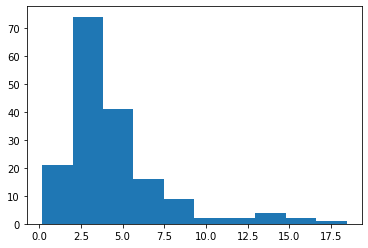

In [22]:
#show histogram of std
import matplotlib.pyplot as plt
plt.hist(img_std_signal[all_subjects['y']=='correct-go'])

(array([11.,  6.,  2.,  0.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 2.3291792 ,  3.21604096,  4.10290272,  4.98976447,  5.87662623,
         6.76348798,  7.65034974,  8.5372115 ,  9.42407325, 10.31093501,
        11.19779677]),
 <BarContainer object of 10 artists>)

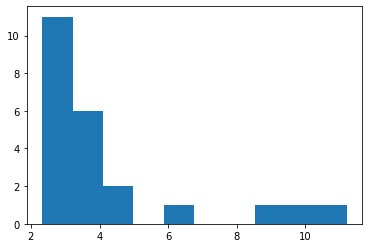

In [23]:
#show histogram of std
import matplotlib.pyplot as plt
plt.hist(img_std_signal[all_subjects['y']=='correct-stop'])

In [28]:
#cut down to just 9 subjects
selected_subjs={}
print(all_subjects.keys())
num_subjs = 9
#select subjs
subjs = all_subjects['metadata']['subject'].unique()
subjs.sort()
selected_sub_ids=subjs[0:num_subjs]
#get index of selected subjs
selected_subjs_idx_bool = all_subjects['metadata']['subject'].isin(selected_sub_ids)
#get list of True indices
selected_subjs_idx = selected_subjs_idx_bool[selected_subjs_idx].index.tolist()


dict_keys(['X', 'y', 'groups', 'metadata', 'y_cat', 'y_int'])


In [30]:

subjs = all_subjects['metadata']['subject'].unique()
selected_subjs['X'] = nib.funcs.concat_images([all_subjects['X'].slicer[...,s] for s in selected_subjs_idx])
selected_subjs['y'] = all_subjects['y'][selected_subjs_idx_bool]


TypeError: cannot do slice indexing on RangeIndex with these indexers [0        True
1        True
2        True
3        True
4        True
        ...  
3166    False
3167    False
3168    False
3169    False
3170    False
Name: subject, Length: 3171, dtype: bool] of type Series

In [32]:
selected_subjs['y'] = all_subjects['y'][selected_subjs_idx_bool]
selected_subjs['groups'] = all_subjects['groups'][selected_subjs_idx_bool]
selected_subjs['metadata'] = all_subjects['metadata'][selected_subjs_idx_bool]

In [37]:
# get the PFC mask
mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [38]:
#convert the y array to an integer array representing the string values of the y array
selected_subjs['y_cat'] = selected_subjs['y'].astype('category')
selected_subjs['y_int']=selected_subjs['y_cat'].cat.codes

# Training

I'm going to start with `cv_train_test_sets` and see how that goes. It sems likely it'll have to be re-written somewhat, but it might be a good starting point.

I think I need to run this without all the extra scaffolding--just tresting the Decoder on the data until I get something sensible. At the very least we need to know the Decoder object is handling balanced classes correctly.

In [ ]:
# use add PFC mask.ipynb to figure out how to get a PFC mask onto this data.

In [39]:
dec_main = Decoder(standardize=True,cv=GroupKFold(3),scoring='roc_auc',n_jobs=cpus_to_use,mask=mask_nifti)
cv_results = cv_train_test_sets(
    trainset_X = selected_subjs['X'],
    trainset_y = selected_subjs['y_int'],
    trainset_groups = selected_subjs['metadata']['subject'],
    decoders = [dec_main],
    cv=KFold(n_splits=3) # we use KFold, not GroupKfold, because it's splitting on Group anyway
    )

Groups are the same.
fold 1 of 3
In order to test on a training group of 6 items, holding out the following subjects:['DEV015' 'DEV006' 'DEV009']. prepping fold data.... fitting.... 4.9 GiB. trying decoder 1 of 1. predicting. test score was:. 0.5122285267071023
fold 2 of 3
In order to test on a training group of 6 items, holding out the following subjects:['DEV010' 'DEV005' 'DEV011']. prepping fold data.... fitting.... 5.0 GiB. trying decoder 1 of 1. 

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.43445692883895126
fold 3 of 3
In order to test on a training group of 6 items, holding out the following subjects:['DEV012' 'DEV013' 'DEV014']. prepping fold data.... fitting.... 4.9 GiB. trying decoder 1 of 1. 

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/decoding/decoder.py:141: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.5957894736842105


In [40]:
cv_results_dict = {
    'test_scores':cv_results[0],
    'results':cv_results[1],
    'results_by_trainset_item':cv_results[2],
}

In [41]:
cv_results_dict['results_by_trainset_item']

,y,group,y_pred
0,1,DEV005,0
1,0,DEV005,0
2,0,DEV005,0
3,0,DEV005,1
4,0,DEV005,1
...,...,...,...
912,0,DEV015,1
913,0,DEV015,0
914,1,DEV015,0
915,0,DEV015,1


The following is derived from 3-fold cross-validation, and should indicate train/test performance classifying trials across subjects.

In [50]:
from sklearn.metrics import precision_recall_fscore_support
#get precision and recall
print(precision_recall_fscore_support(
    cv_results_dict['results_by_trainset_item']['y'],
cv_results_dict['results_by_trainset_item']['y_pred'].astype(int),average='macro'))

#get roc_auc
from sklearn.metrics import roc_auc_score
print(roc_auc_score(
    cv_results_dict['results_by_trainset_item']['y'],
    cv_results_dict['results_by_trainset_item']['y_pred']))

(0.5015090495368123, 0.5040220259845717, 0.4038898145712142, None)
0.5040220259845718
